# Unsupervised Machine Learning

In this example, we will demonstrate how to fit and score an unsupervised learning model with a [sample of Landsat 8 data](https://github.com/locationtech/rasterframes/tree/develop/pyrasterframes/src/test/resources).

## Imports and Data Preparation



In [1]:
from IPython.core.display import display
import pyrasterframes.rf_ipython
from pyrasterframes.utils import create_rf_spark_session

import os

spark = create_rf_spark_session()


We import various Spark components needed to construct our `Pipeline`.



In [2]:
import pandas as pd
from pyrasterframes import TileExploder
from pyrasterframes.rasterfunctions import *

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline


The first step is to create a Spark DataFrame of our imagery data. To achieve that we will create a catalog DataFrame using the pattern from [the I/O page](raster-io.html#Single-Scene--Multiple-Bands). In the catalog, each row represents a distinct area and time, and each column is the URI to a band's image product. The resulting Spark DataFrame may have many rows per URI, with a column corresponding to each band.




In [3]:
filenamePattern = "https://github.com/locationtech/rasterframes/" \
                  "raw/develop/core/src/test/resources/L8-B{}-Elkton-VA.tiff"
catalog_df = pd.DataFrame([
    {'b' + str(b): filenamePattern.format(b) for b in range(1, 8)}
])

df = spark.read.raster(catalog_df, catalog_col_names=catalog_df.columns)
df = df.withColumn('crs', rf_crs(df.b1)) \
       .withColumn('extent', rf_extent(df.b1))
df.printSchema()

root
 |-- b1_path: string (nullable = false)
 |-- b2_path: string (nullable = false)
 |-- b3_path: string (nullable = false)
 |-- b4_path: string (nullable = false)
 |-- b5_path: string (nullable = false)
 |-- b6_path: string (nullable = false)
 |-- b7_path: string (nullable = false)
 |-- b1: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- b2: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = fals


## Create ML Pipeline

SparkML requires that each observation be in its own row, and features for each observation be packed into a single `Vector`. For this unsupervised learning problem, we will treat each _pixel_ as an observation and each band as a feature. The first step is to "explode" the _tiles_ into a single row per pixel. In RasterFrames, generally a pixel is called a @ref:[`cell`](concepts.md#cell).



In [4]:
exploder = TileExploder()


To "vectorize" the the band columns, we use the SparkML `VectorAssembler`. Each of the seven bands is a different feature.



In [5]:
assembler = VectorAssembler() \
    .setInputCols(list(catalog_df.columns)) \
    .setOutputCol("features")


For this problem, we will use the K-means clustering algorithm and configure our model to have 5 clusters.



In [6]:
kmeans = KMeans().setK(5).setFeaturesCol('features')


We can combine the above stages into a single [`Pipeline`](https://spark.apache.org/docs/latest/ml-pipeline.html).



In [7]:
pipeline = Pipeline().setStages([exploder, assembler, kmeans])


## Fit the Model and Score

Fitting the _pipeline_ actually executes exploding the _tiles_, assembling the features _vectors_, and fitting the K-means clustering model.



In [8]:
model = pipeline.fit(df)


We can use the `transform` function to score the training data in the fitted _pipeline_ model. This will add a column called `prediction` with the closest cluster identifier.



In [9]:
clustered = model.transform(df)


Now let's take a look at some sample output.



In [10]:
clustered.select('prediction', 'extent', 'column_index', 'row_index', 'features')

prediction,extent,column_index,row_index,features
4,"[703986.502389, 4249551.61978, 709549.093643, 4254601.8671]",0,0,"[9470.0,8491.0,7805.0,6697.0,17507.0,10338.0,7235.0]"
4,"[703986.502389, 4249551.61978, 709549.093643, 4254601.8671]",1,0,"[9566.0,8607.0,8046.0,6898.0,18504.0,11545.0,7877.0]"
1,"[703986.502389, 4249551.61978, 709549.093643, 4254601.8671]",2,0,"[9703.0,8808.0,8377.0,7222.0,20556.0,13207.0,8686.0]"
1,"[703986.502389, 4249551.61978, 709549.093643, 4254601.8671]",3,0,"[9856.0,8983.0,8565.0,7557.0,19479.0,13203.0,9065.0]"
1,"[703986.502389, 4249551.61978, 709549.093643, 4254601.8671]",4,0,"[10105.0,9270.0,8851.0,7912.0,19074.0,12737.0,8947.0]"



If we want to inspect the model statistics, the SparkML API requires us to go through this unfortunate contortion to access the clustering results:



In [11]:
cluster_stage = model.stages[2]


We can then compute the sum of squared distances of points to their nearest center, which is elemental to most cluster quality metrics.



In [12]:
metric = cluster_stage.computeCost(clustered)
print("Within set sum of squared errors: %s" % metric)

Within set sum of squared errors: 224457400736.95737



## Visualize Prediction

We can recreate the tiled data structure using the metadata added by the `TileExploder` pipeline stage.



In [13]:
from pyrasterframes.rf_types import CellType

tile_dims = df.select(rf_dimensions(df.b1).alias('dims')).first()['dims']
retiled = clustered.groupBy('extent', 'crs') \
    .agg(
        rf_assemble_tile('column_index', 'row_index', 'prediction',
            tile_dims['cols'], tile_dims['rows'], CellType.int8()).alias('prediction')
)


The resulting output is shown below.



rf_agg_overview_raster
""

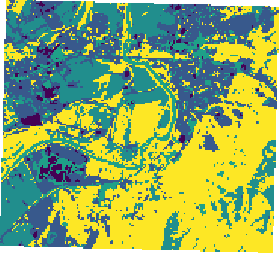

In [14]:
from pyrasterframes.rf_types import Extent
aoi = Extent.from_row(
    retiled.agg(rf_agg_reprojected_extent('extent', 'crs', 'epsg:3857')) \
           .first()[0]
)

retiled.select(rf_agg_overview_raster('prediction', 558, 507, aoi, 'extent', 'crs'))

In [15]:
#For comparison, the true color composite of the original data.
#  this is really dark
df.select(rf_render_png('b4', 'b3', 'b2'))